# ÂØºÂÖ•ÂåÖ

In [1]:
import random
import gymnasium as gym
import numpy as np
import torch
import torch.nn.functional as F
from torch.distributions import Normal
import rl_utils
import os

# ÁΩëÁªú

In [10]:
class PolicyNetContinuous(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim, action_bound):
        super().__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc_mu = torch.nn.Linear(hidden_dim, action_dim)
        self.fc_std = torch.nn.Linear(hidden_dim, action_dim)
        self.action_bound = action_bound

    def forward(self, x):
        x = F.relu(self.fc1(x))
        mu = self.fc_mu(x)
        std = F.softplus(self.fc_std(x))
        dist = Normal(mu, std)
        # rsample()ÊòØÈáçÂèÇÊï∞ÂåñÈááÊ†∑, ËæìÂá∫‰∏Ä‰∏™ÈááÊ†∑ÂÄº(Âä®‰Ωú), Áõ¥Êé•sample‰ºöÈòªÁ¢çËÆ°ÁÆóÂõæÊ¢ØÂ∫¶Êõ¥Êñ∞
        normal_sample = dist.rsample()
        log_prob = dist.log_prob(normal_sample)  # ËæìÂá∫ÁöÑÊòØËØ•Âä®‰ΩúÁöÑÂØπÊï∞Ê¶ÇÁéáÂØÜÂ∫¶
        action = torch.tanh(normal_sample)
        # actionÁªèËøátanhÁöÑÂèòÊç¢ÔºåÁ≠ñÁï•‰∏çÂÜçÊòØÈ´òÊñØÂàÜÂ∏ÉÔºåÈáçÊñ∞ËÆ°ÁÆóÂØπÊï∞Ê¶ÇÁéá
        log_prob = log_prob - torch.log(1 - action.pow(2) + 1e-7)
        action = action * self.action_bound  # Áº©ÊîæÂà∞Âä®‰ΩúÁ©∫Èó¥
        return action, log_prob


class QValueNetContinuous(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super().__init__()
        self.fc1 = torch.nn.Linear(state_dim + action_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.fc_out = torch.nn.Linear(hidden_dim, 1)

    def forward(self, x, a):
        cat = torch.cat([x, a], dim=1)
        x = F.relu(self.fc1(cat))
        x = F.relu(self.fc2(x))
        return self.fc_out(x)

# SACËøûÁª≠Âä®‰Ωú

In [11]:
class SACContinuous:
    ''' Â§ÑÁêÜËøûÁª≠Âä®‰ΩúÁöÑSACÁÆóÊ≥ï '''
    def __init__(self, state_dim, hidden_dim, action_dim, action_bound, 
                 actor_lr, critic_lr, alpha_lr, target_entropy, tau, gamma, device):
        self.actor = PolicyNetContinuous(state_dim, hidden_dim, action_dim, action_bound).to(device)  # Á≠ñÁï•ÁΩëÁªú
        self.critic_1 = QValueNetContinuous(state_dim, hidden_dim, action_dim).to(device)  # Á¨¨‰∏Ä‰∏™QÁΩëÁªú
        self.critic_2 = QValueNetContinuous(state_dim, hidden_dim, action_dim).to(device)  # Á¨¨‰∫å‰∏™QÁΩëÁªú
        self.target_critic_1 = QValueNetContinuous(state_dim, hidden_dim, action_dim).to(device)  # Á¨¨‰∏Ä‰∏™ÁõÆÊ†áQÁΩëÁªú
        self.target_critic_2 = QValueNetContinuous(state_dim, hidden_dim, action_dim).to(device)  # Á¨¨‰∫å‰∏™ÁõÆÊ†áQÁΩëÁªú
        # ‰ª§ÁõÆÊ†áQÁΩëÁªúÁöÑÂàùÂßãÂèÇÊï∞ÂíåQÁΩëÁªú‰∏ÄÊ†∑
        self.target_critic_1.load_state_dict(self.critic_1.state_dict())
        self.target_critic_2.load_state_dict(self.critic_2.state_dict())
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=actor_lr)
        self.critic_1_optimizer = torch.optim.Adam(self.critic_1.parameters(), lr=critic_lr)
        self.critic_2_optimizer = torch.optim.Adam(self.critic_2.parameters(), lr=critic_lr)
        # ‰ΩøÁî®alphaÁöÑlogÂÄº, ÂèØ‰ª•‰ΩøËÆ≠ÁªÉÁªìÊûúÊØîËæÉÁ®≥ÂÆö
        self.log_alpha = torch.tensor(np.log(0.01), dtype=torch.float)  # Áî®‰∫éÊéßÂà∂ÁÜµÁöÑÈáçË¶ÅÁ®ãÂ∫¶
        self.log_alpha.requires_grad = True  # ÂèØ‰ª•ÂØπalphaÊ±ÇÊ¢ØÂ∫¶
        self.log_alpha_optimizer = torch.optim.Adam([self.log_alpha], lr=alpha_lr)
        self.target_entropy = target_entropy  # ÁõÆÊ†áÁÜµÁöÑÂ§ßÂ∞è, ÂéüËÆ∫ÊñáËÆ§‰∏∫Â∫îËØ•Á≠â‰∫éË¥üÁöÑÂä®‰ΩúÁ©∫Èó¥
        self.gamma = gamma
        self.tau = tau
        self.device = device

    def take_action(self, state) -> (int | list[float]):
        state = torch.tensor(np.array(state), dtype=torch.float).to(self.device)
        action = [self.actor(state)[0].item()]
        return action

    def calc_target(self, rewards, next_states, dones, truncated):  # ËÆ°ÁÆóÁõÆÊ†áQÂÄº
        next_actions, log_prob = self.actor(next_states)
        entropy = -log_prob  # ÁÜµ = -ÂØπÊï∞Âä®‰ΩúÊ¶ÇÁéá
        q1_value = self.target_critic_1(next_states, next_actions)
        q2_value = self.target_critic_2(next_states, next_actions)
        next_value = torch.min(q1_value, q2_value) + self.log_alpha.exp() * entropy
        td_target = rewards + self.gamma * next_value * (1 - dones | truncated)
        return td_target

    def soft_update(self, net, target_net):
        for param_target, param in zip(target_net.parameters(), net.parameters()):
            param_target.data.copy_(param_target.data * (1.0 - self.tau) + param.data * self.tau)

    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'], dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions'], dtype=torch.float).view(-1, 1).to(self.device)
        rewards = torch.tensor(transition_dict['rewards'], dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'], dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'], dtype=torch.int).view(-1, 1).to(self.device)
        truncated = torch.tensor(transition_dict['truncated'], dtype=torch.int).view(-1, 1).to(self.device)
        # Âíå‰πãÂâçÁ´†ËäÇ‰∏ÄÊ†∑, ÂØπÂÄíÁ´ãÊëÜÁéØÂ¢ÉÁöÑÂ•ñÂä±ËøõË°åÈáçÂ°ë‰ª•‰æøËÆ≠ÁªÉ
        rewards = (rewards + 8.0) / 8.0

        # Êõ¥Êñ∞‰∏§‰∏™QÁΩëÁªú
        td_target = self.calc_target(rewards, next_states, dones, truncated)
        critic_1_loss = torch.mean(F.mse_loss(self.critic_1(states, actions), td_target.detach()))
        critic_2_loss = torch.mean(F.mse_loss(self.critic_2(states, actions), td_target.detach()))
        self.critic_1_optimizer.zero_grad()
        critic_1_loss.backward()
        self.critic_1_optimizer.step()
        self.critic_2_optimizer.zero_grad()
        critic_2_loss.backward()
        self.critic_2_optimizer.step()

        # Êõ¥Êñ∞Á≠ñÁï•ÁΩëÁªú
        new_actions, log_prob = self.actor(states)
        entropy = -log_prob
        q1_value = self.critic_1(states, new_actions)
        q2_value = self.critic_2(states, new_actions)
        actor_loss = torch.mean(-self.log_alpha.exp() * entropy - torch.min(q1_value, q2_value))
        
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # Êõ¥Êñ∞alphaÂÄº
        alpha_loss = torch.mean((entropy - self.target_entropy).detach() * self.log_alpha.exp())
        self.log_alpha_optimizer.zero_grad()
        alpha_loss.backward()
        self.log_alpha_optimizer.step()
        
        self.soft_update(self.critic_1, self.target_critic_1)
        self.soft_update(self.critic_2, self.target_critic_2)

# ÂàùÂßãÂåñÂèÇÊï∞

In [12]:
# ÁéØÂ¢ÉÁõ∏ÂÖ≥
env_name = 'Pendulum-v1'
env = gym.make(env_name)
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

# SACÁÆóÊ≥ïÁõ∏ÂÖ≥
PATH = 'checkpoints/SAC_PDv1_te.pt'
actor_lr = 3e-4
critic_lr = 3e-3
alpha_lr = 3e-4
total_epochs = 10
total_episodes = 200
gamma = 0.99
tau = 0.005  # ËΩØÊõ¥Êñ∞ÂèÇÊï∞
buffer_size = 100000
minimal_size = 1000
batch_size = 64
target_entropy = -env.action_space.shape[0]  # ÂéüËÆ∫ÊñáËÆ§‰∏∫ÊòØÂä®‰ΩúÁ©∫Èó¥ÁöÑË¥üÊï∞, torchrlÁªôÁöÑÈªòËÆ§ÂÄºÊòØ-torch.prod(n_actions)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)
replay_buffer = rl_utils.ReplayBuffer(buffer_size)

# Á•ûÁªèÁΩëÁªúÁõ∏ÂÖ≥
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
action_bound = env.action_space.high[0]  # Âä®‰ΩúÊúÄÂ§ßÂÄº
hidden_dim = 128

# ÂÖ∂‰ªñ
agent = SACContinuous(state_dim, hidden_dim, action_dim, action_bound, 
                      actor_lr, critic_lr, alpha_lr, target_entropy, tau, 
                      gamma, device)

cuda


# Ê£ÄÊü•ÁÇπÂáΩÊï∞

In [39]:
def read_ckp(ckp_path):
    if os.path.exists(ckp_path):
        checkpoint = torch.load(ckp_path)
        s_epoch = checkpoint['epoch']
        s_episode = checkpoint['episode']
        agent.actor.load_state_dict(checkpoint['actor_best_weight'])
        agent.critic_1.load_state_dict(checkpoint['critic_1_best_weight'])
        agent.critic_2.load_state_dict(checkpoint['critic_2_best_weight'])
        return_list = checkpoint['return_list']
        return s_epoch, s_episode, return_list
    else:
        s_epoch = 0
        s_episode = 0
        return_list = []
        return s_epoch, s_episode, return_list

## ËØªÂèñÊ£ÄÊü•ÁÇπ

In [40]:
s_epoch, s_episode, return_list = read_ckp(PATH)

# ËÆ≠ÁªÉÂáΩÊï∞

In [41]:
return_list = rl_utils.train_off_policy_agent(env, agent, s_epoch, total_epochs, s_episode, total_episodes, 
                                              replay_buffer, minimal_size, batch_size, return_list, PATH, 3)

ÊÄªËÄóÊó∂: 61ÂàÜÈíü


# ‰ΩúÂõæ

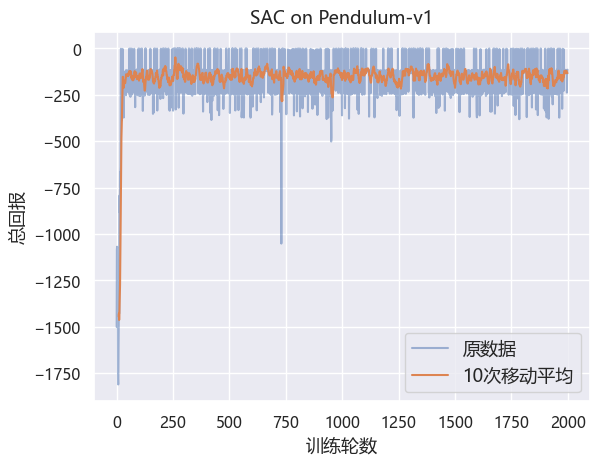

In [43]:
rl_utils.picture_return(return_list, 'SAC', env_name)

# ÊºîÁ§∫Á≠ñÁï•

Âπ≥ÂùáÂõûÊä•:  -141.421


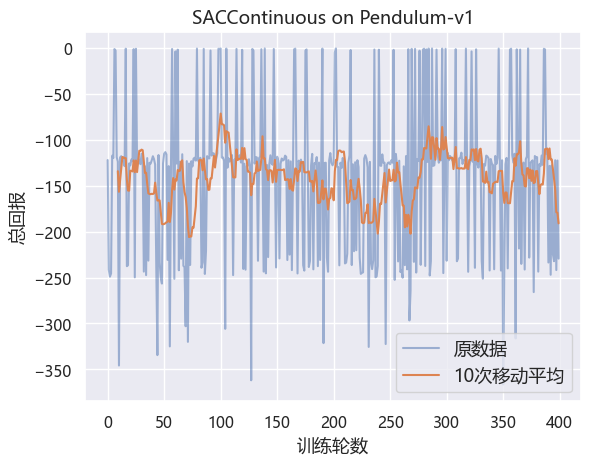

In [44]:
test_list = rl_utils.show_gym_policy(env_name, agent, 'rgb_array', epochs=400, model_type='AC', if_return=True)

Âπ≥ÂùáÂõûÊä•:  -108.089


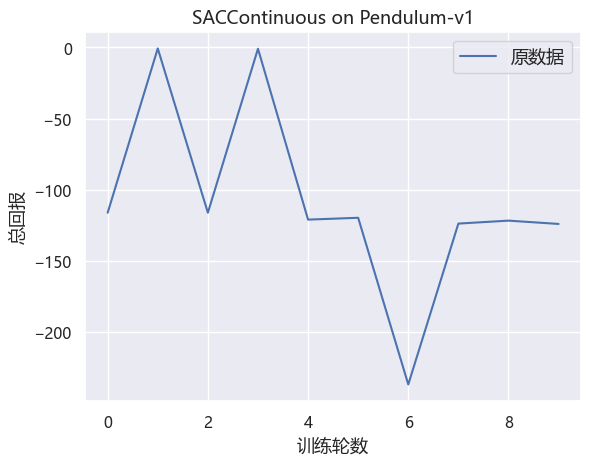

In [45]:
view_list = rl_utils.show_gym_policy(env_name, agent, 'human', epochs=10, model_type='AC', if_return=True)

# ‚úÖSACÂü∫Êú¨ÊÄùÊÉ≥

Âü∫Êú¨ÊÄùË∑ØÊòØ, ÂØπÁΩëÁªúËæìÂÖ•Áä∂ÊÄÅ, ÁΩëÁªúÁªôÂá∫Âä®‰ΩúÂíåËØ•Âä®‰ΩúÁöÑÂØπÊï∞Ê¶ÇÁéá, ËÄåÊääÂä®‰ΩúÁöÑÂØπÊï∞Ê¶ÇÁéáÂèñË¥üÂ∞±ÊòØÁÜµ, ÁÜµË∂äÂ§ß, ‰ª£Ë°®ËØ•Âä®‰ΩúÁöÑ‰∏çÁ°ÆÂÆöÊÄßË∂äÂ§ß, ‰πüÂ∞±ÊòØÂèëÁîüÊ¶ÇÁéáËæÉÂ∞è, ÂèçËøáÊù•, ÁÜµË∂äÂ∞è, ËØ¥ÊòéÁ°ÆÂÆöÊÄßË∂äÂ§ß, SACÊ®°ÂûãÁöÑÁõÆÊ†áÂ∞±ÊòØÂ∏åÊúõÁ≠ñÁï•ÁöÑÂõûÊä•ÂíåÁÜµÈÉΩÂ∞ΩÂèØËÉΩÂ§ßÔºåÁÜµÂâçÈù¢Êúâ‰∏Ä‰∏™$\alpha$Ë∞ÉÊï¥ÁÜµÁöÑÈáçË¶ÅÊÄß, ‰πüÁß∞‰∏∫`Ê∏©Â∫¶`„ÄÇ
$$
\pi^* = \underset{\pi}{\operatorname{argmax}}\mathbb{E}_{\pi}\left[\underset{t}{\sum}r(s_t,a_t)+\alpha\mathcal{H}(\pi(\cdot|s_t)) \right]
$$
‰πüÂèØ‰ª•ÂÜôÊàêÊÄªÁöÑËÆ≠ÁªÉÁõÆÊ†á
$$
J(\pi)=\sum^{T}_{t=0}\mathbb{E}_{(s_t,a_t)\sim\rho_\pi}[r(s_t,a_t)+\alpha\mathcal{H}(\pi(\cdot|s_t))]
$$

ÂÖ∂‰∏≠ÁÜµÂ∞±ÊòØÂØπÊï∞ÂåñÁöÑÂä®‰ΩúÊ¶ÇÁéáÂä†Ë¥üÂè∑, Âú®‰ª£Á†ÅÈáåÈù¢Ë°®Áé∞‰∏∫ÂèòÈáè`entropy`

$$
\mathcal{H}(\pi(\cdot|s_t)) = -\log(\pi(a|s))
$$

Âπ∂‰∏îVÂáΩÊï∞‰πüÂä†ÂÖ•ÁÜµ, Â¶ÇÊûú‰∏çËÄÉËôëË¥üÂè∑Â∫îËØ•ÊòØÂä†‰∏ä$\alpha\mathcal{H}(\pi(\cdot|s_t))$, ÊîπÂÜô‰∏∫$V^\pi_{soft}(s)$
$$
V^\pi_{soft}(s^\prime)=\mathbb{E}_{(s^\prime,a^\prime)\sim\rho_\pi}[Q_{soft}(s^\prime,a^\prime)-\alpha\log(\pi(a^\prime|s^\prime))]
$$

Âõ†Ê≠§QÂáΩÊï∞ÁöÑË¥ùÂ∞îÊõºÊñπÁ®ãË∑ü‰ª•ÂâçÁ±ª‰ºº 
$$
\begin{align}
Q^\pi_{soft}(s,a) 
& = r(s,a)+\gamma\mathbb{E}_{(s^\prime,a^\prime)\sim\rho_\pi}[Q(s^\prime,a^\prime)-\alpha\log(\pi(a^\prime|s^\prime))]\\

& = r(s,a)+\gamma\mathbb{E}_{s^\prime\sim\rho}[V^\pi_{soft}(s^\prime)]
\end{align}
$$


üòØ $Q_{soft}$ÁöÑ**ÁõÆÊ†áÂáΩÊï∞**, ÂØπÂ∫î‰ª£Á†Å`SAC`Á±ª‰∏≠ÁöÑ`calc_target`ÊñπÊ≥ï, ÂÖ¨Âºè‰∏∫
$$
\begin{align}
J_Q(\theta) &= \mathbb{E}_{(s_t,a_t,s_{t+1})\sim \mathcal{D}}\left[\frac{1}{2}(Q_\theta(s_t,a_t)-(r(s_t,a_t)+\gamma V_{\bar{\theta}}(s_{t+1})))^2\right] \\
&=\mathbb{E}_{(s_t,a_t,s_{t+1})\sim \mathcal{D}}\left[\frac{1}{2}(Q_\theta(s_t,a_t)-(r(s_t,a_t)+\gamma (Q_{\bar \theta}(s_{t+1},a_{t+1})-
\alpha\log(\pi(a_{t+1}|s_{t+1})))^2\right]
\end{align}
$$

ÂÖ∂‰∏≠$Q_{\bar \theta}$ÊòØ‰∏§‰∏™ËØÑËÆ∫ÂëòÁΩëÁªúÁªôÂá∫ÁöÑ‰ª∑ÂÄºËØÑ‰ª∑ÁöÑËæÉÂ∞èÁöÑÈÇ£‰∏™ÔºåËøôÈáåÂØπ$\theta$Ê±ÇÊ¢ØÂ∫¶ÊòØÂæàÁÆÄÂçïÁöÑ„ÄÇ

üòØ $V_{soft}$, Âç≥Á≠ñÁï•ÁΩëÁªúPolicyÁöÑ**ÁõÆÊ†áÂáΩÊï∞**‰∏∫

$$
\begin{align}
J_\pi(\phi)
&= D_{KL}\left(\pi_k(\cdot|s_t)||\frac{exp(\frac{1}{\alpha}Q^\pi_{soft}(s_t,\cdot))}{Z_{soft}^\pi(s_t)}\right)\\
&= \mathbb{E}_{s_t\sim\mathcal{D},a\sim\pi_\phi}\left[\log\pi_\phi(a_t|s_t)-\frac{1}{\alpha}Q_{\bar \theta}(s_t,a_t)+\log Z(s_t)\right]
\end{align}
$$
ÂÖ∂‰∏≠KLÊï£Â∫¶ÂÖ¨ÂºèÔºö
$$
\begin{align}
D_{KL}(P||Q) &= \int_x p(x)\operatorname{log}\frac{P(x)}{Q(x)}\operatorname{d}x \\
&= \mathbb{E}\left[\operatorname{log}\frac{P(x)}{Q(x)} \right]

\end{align}
$$

Áî±‰∫éÊ±ÇÊ¢ØÂ∫¶Êó∂‰πü‰∏çÈúÄË¶ÅÂØπ$Z$Ê±ÇÊ¢ØÂ∫¶ÔºåËÄå‰∏îÊú¨Êù•‰πü‰∏çÁü•ÈÅì$Z$ÔºåÊâÄ‰ª•‰ª£Á†ÅÈáåÈù¢ÂéªÊéâ‰∫ÜÔºå [ÂéüËÆ∫Êñá](https://arxiv.org/pdf/1801.01290.pdf)ÊÄùÊÉ≥‰πüÂ∞±ÊòØËøôÊ†∑Ôºå‰Ωç‰∫éÁ¨¨ÂõõÈ°µÂè≥‰æß‰∏äÈù¢Ôºå‰ª£Á†ÅÈáåÈù¢ËøòÂÖ®ÈÉ®ÂêåÊó∂‰πò‰ª•‰∫Ü$\alpha$ÔºåËøôÈáåÂ∞±‰∏ç‰πò‰∫ÜÔºåÁõ¥Êé•ÂÜô‰∏∫

$$
J_\pi(\phi) = \mathbb{E}_{s_t\sim\mathcal{D},a\sim\pi_\phi}\left[\log\pi_\phi(a_t|s_t)-\frac{1}{\alpha}Q_{\bar \theta}(s_t,a_t)\right]
$$

Ëøô‰∏™ÁõÆÊ†áÂáΩÊï∞ÊòØKLÊï£Â∫¶ÔºåË°®Á§∫‰∏§‰∏™ÂàÜÂ∏É‰πãÈó¥ÁöÑÂ∑ÆÂºÇÁ®ãÂ∫¶ÔºåÂáèÂ∞èËøô‰∏™ÁõÆÊ†áÂáΩÊï∞Â∞±ÊòØËØïÂõæ‰ΩøÁ≠ñÁï•ÂáΩÊï∞$\pi_k$ÁöÑÂàÜÂ∏ÉÁúãËµ∑Êù•Êõ¥ÂÉèÊòØÁî±ÂáΩÊï∞ZÊ†áÂáÜÂåñÁöÑQÂáΩÊï∞ÁöÑÊåáÊï∞ÂàÜÂ∏ÉÔºõÂÖ∂‰∏≠$a_t$ÊòØÈáçÂèÇÊï∞ÂåñÊù•ÁöÑÔºåÁõÆÁöÑÊòØËÆ©Ê¢ØÂ∫¶Ê≠£Â∏∏Êõ¥Êñ∞Ôºå$\epsilon$ÊòØ‰ªéÈ´òÊñØÂàÜÂ∏ÉÈááÊ†∑ÁöÑÂô™Èü≥„ÄÇÂØπÁ≠ñÁï•ÁõÆÊ†áÂáΩÊï∞ÁöÑÂèÇÊï∞$\phi$Ê±ÇÂØºÊó∂Ôºå‰∏é$Z$Êó†ÂÖ≥Ôºå‰ΩÜÊòØ‰∏éQÊúâÂÖ≥ÔºåÂõ†‰∏∫Q‰∏≠ÁöÑ$a_t$ÊòØ‰ªéÁ≠ñÁï•‰∏≠ÈáçÂèÇÊï∞ÂåñÂèñÂæóÁöÑÔºåÂ¶Ç‰∏ãÈù¢ÂÖ¨Âºè

$$
a_t=f_\phi(\epsilon_t;s_t)=f^\mu_\phi(s_t)+\epsilon_t\cdot f^\mu_\phi(s_t)
$$
Âú®Ê±ÇÁÜµÁöÑÊó∂ÂÄôÔºåÂä®‰Ωú$u$ÂéüÊú¨ÊòØ‰ªéÊ≠£ÊÄÅÂàÜÂ∏ÉÈááÊ†∑ÁöÑÔºå‰ΩÜÊòØÁªèËøá$a=\operatorname{tanh}(u)$ÂéãÁº©Â§ÑÁêÜÔºå‰∏çÂÜçÊòØÊ≠£ÊÄÅÂàÜÂ∏ÉÔºåÈúÄË¶ÅÈáçÊñ∞ËÆ°ÁÆóÊ¶ÇÁéáÔºåÈúÄË¶ÅÊ≥®ÊÑèÁöÑÊòØÔºåËøôÈáåÈááÊ†∑Âà∞ÁöÑÂçï‰∏™Âä®‰ΩúÁöÑÊ¶ÇÁéáÂ∞±ÊòØÊ¶ÇÁéáÂØÜÂ∫¶ÔºåËÄå‰∏çÊòØÊ¶ÇÁéáÂàÜÂ∏ÉÔºåËøôÈáåÁöÑ$\pi$Âíå$\mu$ÈÉΩÊòØÊ¶ÇÁéáÂØÜÂ∫¶ÂáΩÊï∞ÔºåÊé®ÂØºÂ¶Ç‰∏ã

$$
\begin{align}
a &= \operatorname{tanh}(u) \\
\pi(a|s)\operatorname{d}a&=\mu(u|s)\operatorname{d}u\\
\pi(a|s) 
&= \mu(u|s)(\frac{\operatorname{d}a}{\operatorname{d}u})^{-1}\\
ÂÖ∂‰∏≠:\frac{\operatorname{d}a}{\operatorname{d}u} &= 1-\operatorname{tanh}^2u \\
\pi(a|s) &= \mu(u|s)(1-\operatorname{tanh}^2u)^{-1} \\
‰∏§ËæπÂä†ÂØπÊï∞:\operatorname{log}\pi(a|s) 
&= \operatorname{log}\mu(u|s)-\sum^D_{i=1}\operatorname{log}(1-\operatorname{tanh}^2(u_i)) \\
&= \operatorname{log}\mu(u|s)-\sum^D_{i=1}\operatorname{log}(1-a_i^2)
\end{align}
$$


üòØ $\alpha$‰πüÊòØË¶ÅË∞ÉÊï¥ÁöÑ, Â≠òÂú®‰ª•‰∏ãÁ∫¶Êùü‰ºòÂåñ, ÂÖ∂‰∏≠$\mathcal{H}_0$ÊòØÂèØ‰ª•Ë∞ÉÊï¥ÁöÑÂèÇÊï∞„ÄÇ

$$
\underset{\pi}{\operatorname{max}} \mathbb{E}\left[\underset{t}{\sum}r(s_t, a_t) \right] ~~~~ \operatorname{s.t.} ~~~~ \mathbb{E}_{(s_t,a_t)\sim\rho_\pi} \left[-\operatorname{log}(\pi(a_t|s_t)) \right] \geq \mathcal{H}_0
$$

Á∫¶Êùü‰ºòÂåñÈóÆÈ¢ò‰∏≠Ê≤°Êúâ$\alpha$ÔºåÂÆÉÊòØ‰Ωú‰∏∫ÊãâÊ†ºÊúóÊó•‰πòÂ≠êÂá∫Áé∞ÁöÑÔºåÈúÄË¶ÅËΩ¨Âåñ‰∏∫ÂØπÂÅ∂ÈóÆÈ¢òÔºåÂèÇËÄÉ[Á¨¨ÂçÅ‰∏âÁ´† SAC ÁÆóÊ≥ï](https://johnjim0816.com/joyrl-book/#/ch13/main?id=%e8%87%aa%e5%8a%a8%e8%b0%83%e8%8a%82%e6%b8%a9%e5%ba%a6%e5%9b%a0%e5%ad%90)ÔºåÊú™ÂÆåÂÖ®ÁêÜËß£ÔºåËß£Âá∫ÂÖ∂ÁõÆÊ†áÂáΩÊï∞‰∏∫ #ÈóÆÈ¢ò
$$

\begin{align}

J(\alpha)

&= \mathbb{E}_{a_t\sim\pi_t}\left[-\alpha \log \pi_t(a_t|s_t)-\alpha\mathcal{H}_0\right] \\

&= \mathbb{E}_{a_t\sim\pi_t}\left[\alpha(-\log \pi_t(a_t|s_t)-\mathcal{H}_0)\right]

\end{align}

$$
ÂÖ∂‰∏≠$-\log \pi_t(a_t|\pi_t)$‰πüÂ∞±ÊòØÁÜµ`entropy`ÔºåÂØπ$\alpha$Ê±ÇÂØºÔºåÂ∞±Á≠â‰∫éÂ∞èÊã¨Âè∑ÈáåÈù¢ÁöÑÂä®‰ΩúÁÜµÂáèÂéªÁõÆÊ†áÁÜµÔºåÊâÄ‰ª•ËøôÂ∞±ÊòØË¶Å‰ΩøÂæóÂä®‰ΩúÁÜµÈù†ËøëÁõÆÊ†áÁÜµÔºå‰ΩøÂæó$J(\alpha)$ÂèòÂ∞è„ÄÇ

ÂèÇËÄÉ‰∏ãÈù¢Á≠ñÁï•ÁõÆÊ†áÂáΩÊï∞ÔºåÂä®‰ΩúÁÜµÂ§™Â§ßÔºåÂ§ß‰∫éÁõÆÊ†áÁÜµ‰∫ÜÔºåÊ¢ØÂ∫¶Â∞±ÊòØÊ≠£ÁöÑÔºå$\alpha$ÁõÆÊ†áÂáΩÊï∞Âú®Ê¢ØÂ∫¶‰∏ãÈôçÊó∂Â∞±‰ºöÂáèÂ∞è$\alpha$ÔºåÂ∞±ÊòØÊåáÁ≠ñÁï•ÁªôÁöÑÂä®‰ΩúÁöÑÊ¶ÇÁéáÊØîËæÉ‰ΩéÔºåÊãø‰∏çÂáÜÂ∫îËØ•ÊÄé‰πàÂäûÔºåÈúÄË¶ÅÂáèÂ∞è$\alpha$‰ΩøÂæóÊ®°Âûã‰∏ìÊ≥®‰∫éËé∑ÂæóÊõ¥È´òÁöÑÂõûÊä•Ôºå‰πüÂ∞±ÊòØÂ∞ΩÂèØËÉΩÊèêÂçáÂä®‰ΩúÁ°ÆÂÆöÊÄßÔºõËÄåÂä®‰ΩúÁÜµÂ§™Â∞èÔºåÂ∞±ÊÑèÂë≥ÁùÄÁ≠ñÁï•ÂØπÊüê‰∏Ä‰∏™Âä®‰ΩúËøá‰∫éËÇØÂÆöÔºåÂÆπÊòìÈÄ†ÊàêËøáÊãüÂêàÔºåÂ∞±Ë∞ÉÊï¥$\alpha$ÂèòÂ§ßÔºå$\alpha$ÂèòÂ§ßÂ∞±ÂÄæÂêë‰∫éË¶ÅÊ±ÇÂä®‰ΩúÁÜµÂèòÂ§ßÔºåÁ≠â‰∫éÂ∏åÊúõÂä®‰ΩúÊ¶ÇÁéáÈôç‰ΩéÔºåËÆ©Ê®°ÂûãÈáçËßÜÊé¢Á¥¢„ÄÇ

$$
\pi^* = \underset{\pi}{\operatorname{argmax}}\mathbb{E}_{\pi}\left[\underset{t}{\sum}r(s_t,a_t)+\alpha\mathcal{H}(\pi(\cdot|s_t)) \right]
$$
## ÁõÆÊ†áÁÜµ 

 [ÂéüËÆ∫Êñá](https://arxiv.org/pdf/1801.01290.pdf)ËÆ§‰∏∫ËøûÁª≠Âä®‰ΩúÁöÑÁõÆÊ†áÁÜµÁ≠â‰∫éÂä®‰ΩúÁ©∫Èó¥ÁöÑË¥üÂÄºÔºåtorchrl‰∏≠ÈªòËÆ§‰∏∫`torch.prod(n_actions)`ÔºåÂè¶‰∏ÄÁØá[ËÆ∫Êñá](https://arxiv.org/pdf/1910.07207.pdf)ÁªôÂá∫Á¶ªÊï£SACÔºåÁõÆÊ†áÁÜµËÆæÁΩÆ‰∏∫$0.98(-\operatorname{log}(\frac{1}{|A|}))$Ôºå‰æùÊçÆÊú™ËØ¥ÊòéÔºåÂèØËÉΩÂíå‰∫§ÂèâÁÜµÁ±ª‰ººÔºå‰ΩÜÊòØÊÄªÁöÑÊù•ËØ¥‰∏çÂª∫ËÆÆÂ∞ÜSACÂ∫îÁî®‰∫éÁ¶ªÊï£Âä®‰ΩúÁéØÂ¢É„ÄÇ

# SACÁ¶ªÊï£Âä®‰Ωú

In [11]:
import random
import gymnasium as gym
import numpy as np
import torch
import torch.nn.functional as F
from torch.distributions import Normal
import rl_utils
import os

## ÁΩëÁªú

In [12]:
class PolicyNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(PolicyNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return F.softmax(self.fc2(x), dim=1)  # Áõ¥Êé•ËæìÂá∫softmax


class QValueNet(torch.nn.Module):
    ''' Âè™Êúâ‰∏ÄÂ±ÇÈöêËóèÂ±ÇÁöÑQÁΩëÁªú '''
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(QValueNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)

## SAC

In [26]:
class SAC:
    ''' Â§ÑÁêÜÁ¶ªÊï£Âä®‰ΩúÁöÑSACÁÆóÊ≥ï '''
    def __init__(self, state_dim, hidden_dim, action_dim, actor_lr, critic_lr,
                 alpha_lr, target_entropy, tau, gamma, device):
        # Á≠ñÁï•ÁΩëÁªú
        self.actor = PolicyNet(state_dim, hidden_dim, action_dim).to(device)
        # Á¨¨‰∏Ä‰∏™QÁΩëÁªú
        self.critic_1 = QValueNet(state_dim, hidden_dim, action_dim).to(device)
        # Á¨¨‰∫å‰∏™QÁΩëÁªú
        self.critic_2 = QValueNet(state_dim, hidden_dim, action_dim).to(device)
        self.target_critic_1 = QValueNet(state_dim, hidden_dim, action_dim).to(device)  # Á¨¨‰∏Ä‰∏™ÁõÆÊ†áQÁΩëÁªú
        self.target_critic_2 = QValueNet(state_dim, hidden_dim, action_dim).to(device)  # Á¨¨‰∫å‰∏™ÁõÆÊ†áQÁΩëÁªú
        # ‰ª§ÁõÆÊ†áQÁΩëÁªúÁöÑÂàùÂßãÂèÇÊï∞ÂíåQÁΩëÁªú‰∏ÄÊ†∑
        self.target_critic_1.load_state_dict(self.critic_1.state_dict())
        self.target_critic_2.load_state_dict(self.critic_2.state_dict())
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=actor_lr)
        self.critic_1_optimizer = torch.optim.Adam(self.critic_1.parameters(), lr=critic_lr)
        self.critic_2_optimizer = torch.optim.Adam(self.critic_2.parameters(), lr=critic_lr)
        # ‰ΩøÁî®alphaÁöÑlogÂÄº,ÂèØ‰ª•‰ΩøËÆ≠ÁªÉÁªìÊûúÊØîËæÉÁ®≥ÂÆö
        self.log_alpha = torch.tensor(np.log(0.01), dtype=torch.float)
        self.log_alpha.requires_grad = True  # ÂèØ‰ª•ÂØπalphaÊ±ÇÊ¢ØÂ∫¶
        self.log_alpha_optimizer = torch.optim.Adam([self.log_alpha], lr=alpha_lr)
        self.target_entropy = target_entropy  # ÁõÆÊ†áÁÜµÁöÑÂ§ßÂ∞è
        self.gamma = gamma
        self.tau = tau
        self.device = device

    def take_action(self, state):
        state = torch.tensor(state, dtype=torch.float).to(self.device).unsqueeze(0)
        probs = self.actor(state)
        action_dist = torch.distributions.Categorical(probs)
        action = action_dist.sample()
        return action.item()

    # ËÆ°ÁÆóÁõÆÊ†áQÂÄº,Áõ¥Êé•Áî®Á≠ñÁï•ÁΩëÁªúÁöÑËæìÂá∫Ê¶ÇÁéáËøõË°åÊúüÊúõËÆ°ÁÆó
    def calc_target(self, rewards, next_states, dones, truncated):
        next_probs = self.actor(next_states)
        next_log_probs = torch.log(next_probs + 1e-8)
        entropy = -torch.sum(next_probs * next_log_probs, dim=1, keepdim=True)
        q1_value = self.target_critic_1(next_states)
        q2_value = self.target_critic_2(next_states)
        min_qvalue = torch.sum(next_probs * torch.min(q1_value, q2_value), dim=1, keepdim=True)
        next_value = min_qvalue + self.log_alpha.exp() * entropy
        td_target = rewards + self.gamma * next_value * (1 - dones | truncated)
        return td_target

    def soft_update(self, net, target_net):
        for param_target, param in zip(target_net.parameters(), net.parameters()):
            param_target.data.copy_(param_target.data * (1.0 - self.tau) + param.data * self.tau)

    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'], dtype=torch.float).to(self.device)
        # Âä®‰Ωú‰∏çÂÜçÊòØfloatÁ±ªÂûã, Âª∫ËÆÆÂº∫Âà∂int64
        actions = torch.tensor(transition_dict['actions'], dtype=torch.int64).view(-1, 1).to(self.device)  
        rewards = torch.tensor(transition_dict['rewards'], dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'], dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'], dtype=torch.int).view(-1, 1).to(self.device)
        truncated = torch.tensor(transition_dict['truncated'], dtype=torch.int).view(-1, 1).to(self.device)

        # Êõ¥Êñ∞‰∏§‰∏™QÁΩëÁªú
        td_target = self.calc_target(rewards, next_states, dones, truncated)
        critic_1_q_values = self.critic_1(states).gather(1, actions)
        critic_1_loss = torch.mean(F.mse_loss(critic_1_q_values, td_target.detach()))
        critic_2_q_values = self.critic_2(states).gather(1, actions)
        critic_2_loss = torch.mean(F.mse_loss(critic_2_q_values, td_target.detach()))
        self.critic_1_optimizer.zero_grad()
        critic_1_loss.backward()
        self.critic_1_optimizer.step()
        self.critic_2_optimizer.zero_grad()
        critic_2_loss.backward()
        self.critic_2_optimizer.step()

        # Êõ¥Êñ∞Á≠ñÁï•ÁΩëÁªú
        probs = self.actor(states)
        log_probs = torch.log(probs + 1e-8)
        # Áõ¥Êé•Ê†πÊçÆÊ¶ÇÁéáËÆ°ÁÆóÁÜµ
        entropy = -torch.sum(probs * log_probs, dim=1, keepdim=True)
        q1_value = self.critic_1(states)
        q2_value = self.critic_2(states)
        min_qvalue = torch.sum(probs * torch.min(q1_value, q2_value), dim=1, keepdim=True)  # Áõ¥Êé•Ê†πÊçÆÊ¶ÇÁéáËÆ°ÁÆóÊúüÊúõ
        actor_loss = torch.mean(-self.log_alpha.exp() * entropy - min_qvalue)
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # Êõ¥Êñ∞alphaÂÄº
        alpha_loss = torch.mean((entropy - self.target_entropy).detach() * self.log_alpha.exp())
        self.log_alpha_optimizer.zero_grad()
        alpha_loss.backward()
        self.log_alpha_optimizer.step()

        self.soft_update(self.critic_1, self.target_critic_1)
        self.soft_update(self.critic_2, self.target_critic_2)

## Ë∂ÖÂèÇÊï∞

In [27]:
# ÁéØÂ¢ÉÁõ∏ÂÖ≥
env_name = 'CartPole-v1'
env = gym.make(env_name)
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

# SACÁÆóÊ≥ïÁõ∏ÂÖ≥
PATH = 'checkpoints/SAC_CPv1.pt'
actor_lr = 3e-4
critic_lr = 3e-3
alpha_lr = 3e-4
total_epochs = 6
total_episodes = 200
gamma = 0.99
tau = 0.005  # ËΩØÊõ¥Êñ∞ÂèÇÊï∞
buffer_size = 100000
minimal_size = 1000
batch_size = 64
target_entropy = 0.98 * (-np.log(1 / env.action_space.n))  # Á¶ªÊï£Âä®‰ΩúÁõÆÊ†áÁÜµ, Á¶ªÊï£SACËÆ∫ÊñáÁªôÁöÑÁõÆÊ†áÁÜµÊòØ0.98(-log(1/|A|))
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)
replay_buffer = rl_utils.ReplayBuffer(buffer_size)

# Á•ûÁªèÁΩëÁªúÁõ∏ÂÖ≥
state_dim = env.observation_space.shape[0]
hidden_dim = 128
action_dim = env.action_space.n

# Êó†ÈúÄËæìÂÖ•Âä®‰Ωú‰∏äÈôê, Áé∞Âú®Âä®‰ΩúÊòØÁ¶ªÊï£ÁöÑ
agent = SAC(state_dim, hidden_dim, action_dim, actor_lr, critic_lr, alpha_lr,
            target_entropy, tau, gamma, device)

cuda


## ËØªÂèñÊ£ÄÊü•ÁÇπ

In [31]:
def read_ckp(ckp_path):
    if os.path.exists(ckp_path):
        checkpoint = torch.load(ckp_path)
        s_epoch = checkpoint['epoch']
        s_episode = checkpoint['episode']
        agent.actor.load_state_dict(checkpoint['actor_best_weight'])
        agent.critic_1.load_state_dict(checkpoint['critic_1_best_weight'])
        agent.critic_2.load_state_dict(checkpoint['critic_2_best_weight'])
        return_list = checkpoint['return_list']
        return s_epoch, s_episode, return_list
    else:
        s_epoch = 0
        s_episode = 0
        return_list = []
        return s_epoch, s_episode, return_list

In [32]:
s_epoch, s_episode, return_list = read_ckp(PATH)

## ËÆ≠ÁªÉ

In [33]:
return_list = rl_utils.train_off_policy_agent(env, agent, s_epoch, total_epochs, 
                                              s_episode, total_episodes, 
                                              replay_buffer, minimal_size, batch_size, 
                                              return_list, PATH, 3)

ÊÄªËÄóÊó∂: 6ÂàÜÈíü


# ‰ΩúÂõæ

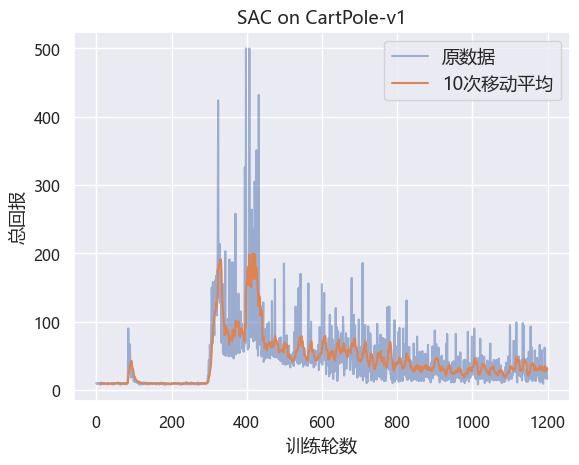

In [34]:
s_epoch, s_episode, return_list = read_ckp(PATH)
rl_utils.picture_return(return_list, 'SAC', env_name)

# ÊºîÁ§∫Á≠ñÁï•

Âπ≥ÂùáÂõûÊä•:  119.75


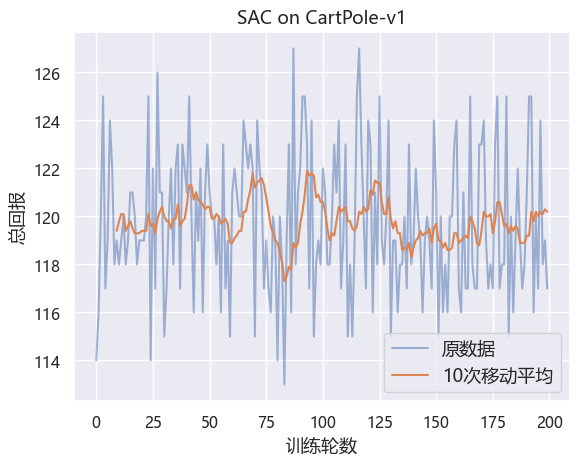

In [69]:
test_list = rl_utils.show_gym_policy(env_name, agent, 'rgb_array', epochs=200, model_type='AC', if_return=True)

In [70]:
rl_utils.show_gym_policy(env_name, agent, 'human', epochs=10, model_type='AC')

Âπ≥ÂùáÂõûÊä•:  121.2


[126.0, 124.0, 120.0, 122.0, 118.0, 116.0, 119.0, 124.0, 125.0, 118.0]